In [1]:
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops

In [2]:
# 加载图像
image = cv2.imread('../data/imgs/1066.png')
# 转换为RGB格式（opencv读取为BGR）
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [3]:
# 加载生成的掩码
mask = cv2.imread('../data/imgs/mask1066.png', cv2.IMREAD_GRAYSCALE)

In [4]:
Y = mask.flatten()
Y = np.where(Y > 128, 1, 0)  # 1为道路，0为非道路
# 将数组转换为Pandas Series
series = pd.Series(Y)
# 使用value_counts方法统计每个元素的出现次数
value_counts = series.value_counts()
# 输出分布情况
print(value_counts)

0    95739
1    29261
Name: count, dtype: int64


In [5]:
# 获取图像的尺寸
h, w, _ = image_rgb.shape
# 将掩码展开为一维向量
# Y = mask.flatten()
# Y = np.where(Y > 128, 1, 0)  # 1为道路，0为非道路
# 转换到HSV颜色空间
image_hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)

# 转换到灰度图像
image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)

# 计算灰度共生矩阵 (GLCM)
glcm = graycomatrix(image_gray, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)

# 提取纹理特征
contrast = graycoprops(glcm, 'contrast')
dissimilarity = graycoprops(glcm, 'dissimilarity')
homogeneity = graycoprops(glcm, 'homogeneity')
energy = graycoprops(glcm, 'energy')
correlation = graycoprops(glcm, 'correlation')
ASM = graycoprops(glcm, 'ASM')

# 构建特征向量 (R, G, B, H, S, V, x, y, contrast, dissimilarity, homogeneity, energy, correlation, ASM)
X = []
for i in range(h):
    for j in range(w):
        pixel = image_rgb[i, j]
        hsv_pixel = image_hsv[i, j]
        
        # 获取当前像素点的纹理特征
        texture_features = [
            contrast[0, 0], dissimilarity[0, 0], homogeneity[0, 0],
            energy[0, 0], correlation[0, 0], ASM[0, 0]
        ]
        
        X.append([
            pixel[0], pixel[1], pixel[2], 
            hsv_pixel[0], hsv_pixel[1], hsv_pixel[2], 
            # i, j,
            *texture_features
        ])

# 将 X 转换为 numpy 数组
X = np.array(X)

# 打印特征向量的形状
print("Feature vector shape:", X.shape)
print(X)


Feature vector shape: (125000, 12)
[[6.90000000e+01 8.50000000e+01 1.00000000e+02 ... 9.75531255e-02
  9.95130023e-01 9.51661229e-03]
 [7.10000000e+01 8.70000000e+01 1.02000000e+02 ... 9.75531255e-02
  9.95130023e-01 9.51661229e-03]
 [7.40000000e+01 8.90000000e+01 1.04000000e+02 ... 9.75531255e-02
  9.95130023e-01 9.51661229e-03]
 ...
 [3.60000000e+01 3.80000000e+01 2.90000000e+01 ... 9.75531255e-02
  9.95130023e-01 9.51661229e-03]
 [3.90000000e+01 4.20000000e+01 3.20000000e+01 ... 9.75531255e-02
  9.95130023e-01 9.51661229e-03]
 [3.90000000e+01 4.10000000e+01 3.20000000e+01 ... 9.75531255e-02
  9.95130023e-01 9.51661229e-03]]


In [6]:
# 划分训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
# 归一化特征
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train.shape

(87500, 12)

In [7]:
# 创建SVM分类器
clf = svm.SVC(kernel='linear')  # 使用线性核

# 训练SVM分类器
clf.fit(X_train, Y_train)

# 在测试集上评估模型
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(Y_test, y_pred))


Accuracy: 0.9393066666666666


In [8]:
print(y_pred)

[1 1 0 ... 1 1 1]


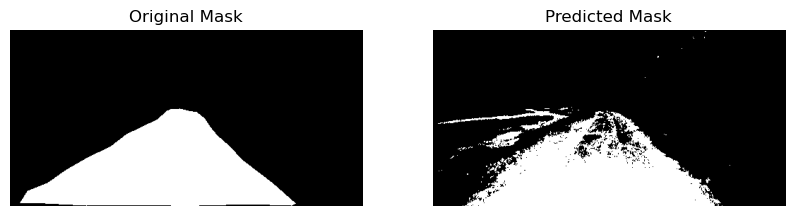

In [9]:
# 生成预测结果的图像
predicted_mask = np.zeros_like(mask)
for i in range(h):
    for j in range(w):
        pixel = image_rgb[i, j]
        hsv_pixel = cv2.cvtColor(np.uint8([[pixel]]), cv2.COLOR_RGB2HSV)[0, 0]
        texture_features = [
            contrast[0, 0], dissimilarity[0, 0], homogeneity[0, 0],
            energy[0, 0], correlation[0, 0], ASM[0, 0]
        ]
        feature_vector = np.array([
            pixel[0], pixel[1], pixel[2],
            hsv_pixel[0], hsv_pixel[1], hsv_pixel[2],
            # i, j,
            *texture_features
        ]).reshape(1, -1)
        feature_vector = scaler.transform(feature_vector)
        predicted_mask[i, j] = clf.predict(feature_vector)[0]

# 显示预测结果的图像
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Mask')
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Predicted Mask')
plt.imshow(predicted_mask, cmap='gray')
plt.axis('off')

plt.show()